# Ejemplo 1 de Regresión: Regresión Lineal

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oramosul/abd-files/blob/main/spark/3-spark-mllib/1-Regresion-RegLineal.ipynb)

In [ ]:
# Solo si se corre en Google Colab
!pip install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression

spark = SparkSession.builder.getOrCreate()

In [ ]:
# Carga de archivos
!wget -q https://raw.githubusercontent.com/oramosul/abd-files/main/spark/datos/Clientes.csv

## 1.&nbsp;Lectura de Datos

Se examinará el dataset llamado "Clientes" que contiene datos del sitio web y de la aplicación móvil de una compañía. Se desea construir un modelo de regresión que prediga el gasto anual del cliente en los productos de la compañía.

In [ ]:
# Cargar los datos
df = spark.read.csv("Clientes.csv", inferSchema=True, header=True)

# Esquema de los datos
df.printSchema()

root
 |-- Email: string (nullable = true)
 |-- Direccion: string (nullable = true)
 |-- Avatar: string (nullable = true)
 |-- Promedio sesion: double (nullable = true)
 |-- Tiempo en App: double (nullable = true)
 |-- Tiempo en SitioWeb: double (nullable = true)
 |-- Tiempo de Membresia: double (nullable = true)
 |-- Gasto Anual: double (nullable = true)



In [ ]:
# Mostrar las 5 primeras filas
df.show(5)

+--------------------+--------------------+----------------+------------------+------------------+------------------+-------------------+------------------+
|               Email|           Direccion|          Avatar|   Promedio sesion|     Tiempo en App|Tiempo en SitioWeb|Tiempo de Membresia|       Gasto Anual|
+--------------------+--------------------+----------------+------------------+------------------+------------------+-------------------+------------------+
|mstephenson@ferna...|835 Frank TunnelW...|          Violet| 34.49726772511229| 12.65565114916675| 39.57766801952616| 4.0826206329529615| 587.9510539684005|
|   hduke@hotmail.com|4547 Archer Commo...|       DarkGreen| 31.92627202636016|11.109460728682564|37.268958868297744|   2.66403418213262| 392.2049334443264|
|    pallen@yahoo.com|24645 Valerie Uni...|          Bisque|33.000914755642675|11.330278057777512|37.110597442120856|  4.104543202376424|487.54750486747207|
|riverarebecca@gma...|1414 David Throug...|     SaddleBrow

## 2.&nbsp;Pre-procesamiento

Para regresión con MLlib los datos deben encontrarse en dos columnas: `("etiquetas","atributos")`, donde `atributos` es una sola columna que contiene una lista con todos los atributos. Para poder crear esta columna `atributos` se debe agrupar los atributos usando un `VectorAssembler`.

In [ ]:
from pyspark.ml.feature import VectorAssembler

En este ejemplo las variables que se utilizará para predecir será solo las variables cuantitativas (Promedio sesión, Tiempo en App, Tiempo en SitioWeb, Tiempo de Membresía) y se descartará las variables cualitativas que posiblemente no aportan información relevante para la predicción.

In [ ]:
# Se utilizará los siguientes atributos bajo el nombre "atributos"
vassembler = VectorAssembler(inputCols=['Promedio sesion',
                                        'Tiempo en App',
                                        'Tiempo en SitioWeb',
                                        'Tiempo de Membresia'],
                             outputCol="Atributos")

# Aplicar a los datos
df2 = vassembler.transform(df)

# Visualizar el resultado
df2.show(5, truncate=False)

+-----------------------------+--------------------------------------------------------+----------------+------------------+------------------+------------------+-------------------+------------------+----------------------------------------------------------------------------+
|Email                        |Direccion                                               |Avatar          |Promedio sesion   |Tiempo en App     |Tiempo en SitioWeb|Tiempo de Membresia|Gasto Anual       |Atributos                                                                   |
+-----------------------------+--------------------------------------------------------+----------------+------------------+------------------+------------------+-------------------+------------------+----------------------------------------------------------------------------+
|mstephenson@fernandez.com    |835 Frank TunnelWrightmouth, MI 82180-9605              |Violet          |34.49726772511229 |12.65565114916675 |39.57766801952616 |4

Se desea predecir el "Gasto Anual" a partir de los atributos anteriores, por lo que el DataFrame que se utilizará contendrá las columnas `Atributos` y `Gasto Anual`.

In [ ]:
# Conjunto de datos para regresión: "atributos, gasto anual"
df_final = df2.select("Atributos", 'Gasto Anual')
df_final.show(5, truncate=False)

+----------------------------------------------------------------------------+------------------+
|Atributos                                                                   |Gasto Anual       |
+----------------------------------------------------------------------------+------------------+
|[34.49726772511229,12.65565114916675,39.57766801952616,4.0826206329529615]  |587.9510539684005 |
|[31.92627202636016,11.109460728682564,37.268958868297744,2.66403418213262]  |392.2049334443264 |
|[33.000914755642675,11.330278057777512,37.110597442120856,4.104543202376424]|487.54750486747207|
|[34.30555662975554,13.717513665142507,36.72128267790313,3.120178782748092]  |581.8523440352177 |
|[33.33067252364639,12.795188551078114,37.53665330059473,4.446308318351434]  |599.4060920457634 |
+----------------------------------------------------------------------------+------------------+
only showing top 5 rows



Separación de los datos en un conjunto de entrenamiento `train_data` y de prueba (evaluación) `test_data`. En este caso se utilizará una proporción de 70% a 30%.

In [ ]:
train_data, test_data = df_final.randomSplit([0.7, 0.3])

Se mostrará un resumen de los datos de entrenamiento (`train_data`) y de los datos de prueba o evaluación (`test_data`).

In [ ]:
train_data.describe().show()
test_data.describe().show()

+-------+------------------+
|summary|       Gasto Anual|
+-------+------------------+
|  count|               352|
|   mean| 498.0788988064192|
| stddev| 79.89918337134029|
|    min|256.67058229005585|
|    max| 765.5184619388373|
+-------+------------------+

+-------+------------------+
|summary|       Gasto Anual|
+-------+------------------+
|  count|               148|
|   mean|502.25166722591837|
| stddev| 78.09685923784843|
|    min|  266.086340948469|
|    max| 744.2218671047146|
+-------+------------------+



## 3.&nbsp;Entrenamiento del Modelo de Regresión

Los datos para cualquier modelo supervisado de Spark MLlib requieren dos columnas: "label" y "features".

* La columna "label" necesita ser numérica, sea de valor real (para una regresión numérica), o de valor entero (para clasificación).
* La columna "feature" contiene un vector con todos los atributos ("features") que corresponden a dicha fila. Usualmente para obtener esta columna se combina varias columnas de atributos en una sola columna

In [ ]:
# Creación de un objeto de Regresión Lineal
reglin = LinearRegression(featuresCol="Atributos",
                          labelCol='Gasto Anual',
                          predictionCol= "Predicción")

# Entrenamiento del modelo (con el conjunto de entrenamiento)
modelo = reglin.fit(train_data)

In [ ]:
modelo

LinearRegressionModel: uid=LinearRegression_6cd5db9027cb, numFeatures=4

In [ ]:
# Coeficientes e intercepto para la regresión lineal
print("Coeficientes:", modelo.coefficients)
print("Intercepto:", modelo.intercept)

Coeficientes: [26.19602830553742,38.69222259269652,0.5278163149139509,61.699941802551656]
Intercepto: -1070.2903545145032


El atributo "summary" contiene información sobre el modelo entrenado (evaluación sobre el conjunto de entrenamiento)

In [ ]:
# Métricas en el conjunto de entrenamiento
print("MAE del conjunto de entrenamiento:", modelo.summary.meanAbsoluteError)
print("RMSE del conjunto de entrenamiento:", modelo.summary.rootMeanSquaredError)
print("r2 del conjunto de entrenamiento:", modelo.summary.r2)

MAE del conjunto de entrenamiento: 7.828169968882957
RMSE del conjunto de entrenamiento: 9.768401225921833
r2 del conjunto de entrenamiento: 0.9850101307444996


El siguiente DataFrame muestra las predicciones del modelo para el conjunto de entrenamiento.

In [ ]:
df_salida = modelo.summary.predictions
df_salida.show(5)

+--------------------+------------------+-----------------+
|           Atributos|       Gasto Anual|       Predicción|
+--------------------+------------------+-----------------+
|[29.5324289670579...| 408.6403510726275|396.8740622754274|
|[30.3931845423455...| 319.9288698031936|330.3133876735965|
|[30.4925366965402...| 282.4712457199145|286.2933805736586|
|[30.5743636841713...|442.06441375806565|441.0413216646548|
|[30.7377203726281...| 461.7807421962299|450.1473823334609|
+--------------------+------------------+-----------------+
only showing top 5 rows



Se realizará una figura de los valores reales ("Gasto Anual") y los valores predichos ("Predicción") para inspección visual  de la predicción en el conjunto de entrenamiento.

In [ ]:
import matplotlib.pyplot as plt

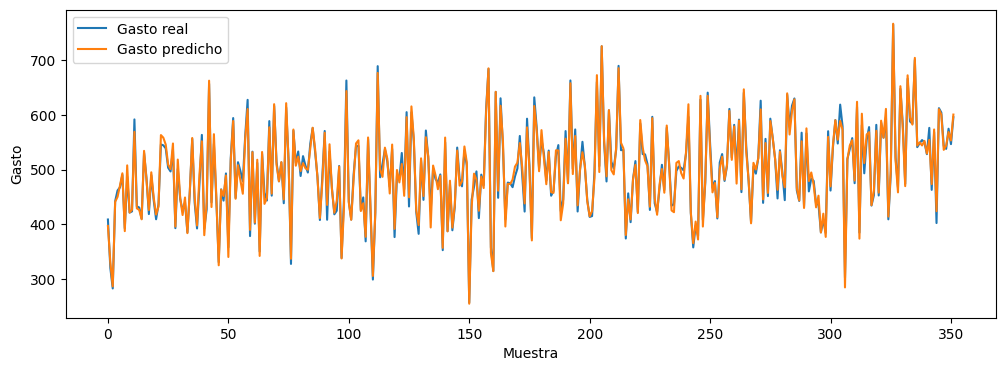

In [ ]:
# Recuperar las columnas de interés: Gasto Anual y Predicción
yreal = df_salida.select('Gasto Anual').collect()
ypred = df_salida.select('Predicción').collect()

# Figuras
plt.figure(figsize=(12, 4))
plt.plot(yreal)
plt.plot(ypred)
plt.legend(['Gasto real', 'Gasto predicho'])
plt.xlabel('Muestra'); plt.ylabel('Gasto');

## 4.&nbsp;Evaluación del Modelo

In [ ]:
# Aplicación del modelo entrenado al conjunto de prueba (test)
resultados = modelo.evaluate(test_data)
resultados

Resultados en el conjunto de evaluación:
* Gasto Anual: etiquetas reales
* Predicción: predicciones realizadas por el modelo

In [ ]:
resultados.predictions.show(5, truncate=False)

+----------------------------------------------------------------------------+------------------+-----------------+
|Atributos                                                                   |Gasto Anual       |Predicción       |
+----------------------------------------------------------------------------+------------------+-----------------+
|[30.81620064887634,11.851398743073142,36.925043038878634,1.0845853030221226]|266.086340948469  |281.9371583755594|
|[30.971675643887767,11.731364294077403,36.07455114016891,4.4263640805293125]|494.6386097568927 |487.1042387157022|
|[31.061325156716126,12.357638107209013,36.16604163340145,4.089330841235956] |487.5554580579016 |492.9379845980584|
|[31.066218161637593,11.735094549013706,36.59937399114725,3.9588922643660966]|448.93329320767435|461.1592352526586|
|[31.128090049616628,13.278956228597714,37.38718052656558,4.626075291951958] |557.2526867470547 |564.0964438563608|
+-----------------------------------------------------------------------

In [ ]:
# Residuos (valores "reales" - valores "predichos")
resultados.residuals.show(8)

+-------------------+
|          residuals|
+-------------------+
| -15.85081742709042|
|  7.534371041190525|
| -5.382526540156789|
|-12.225942044984265|
| -6.843757109306125|
| 11.090008072758565|
| 19.304359116290755|
|  4.618417762842569|
+-------------------+
only showing top 8 rows



In [ ]:
# Métricas en el conjunto de evaluación
print("MAE del conjunto de prueba:", resultados.meanAbsoluteError)
print("RMSE del conjunto de prueba:", resultados.rootMeanSquaredError)
print("MSE del conjunto de prueba:", resultados.meanSquaredError)
print("R^2 del conjunto de prueba:", resultados.r2)

MAE del conjunto de prueba: 8.06888466143344
RMSE del conjunto de prueba: 10.325705023228544
MSE del conjunto de prueba: 106.62018422672719
R^2 del conjunto de prueba: 0.9823998377206965


Inspección visual de la predicción en el conjunto de prueba o evaluación.



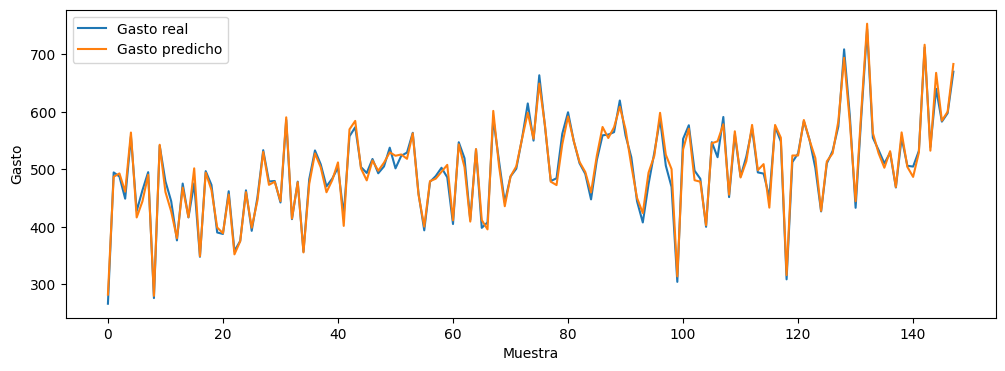

In [ ]:
# Recuperar las columnas de interés: Gasto Anual y Predicción
yreal = resultados.predictions.select('Gasto Anual').collect()
ypred = resultados.predictions.select('Predicción').collect()

# Figuras
plt.figure(figsize=(12, 4))
plt.plot(yreal)
plt.plot(ypred)
plt.legend(['Gasto real', 'Gasto predicho'])
plt.xlabel('Muestra'); plt.ylabel('Gasto');

## 5.&nbsp;Predicción

Una vez entrenado el modelo, se puede utilizar para predecir valores para nuevos conjuntos de datos. En este caso, para realizar esta prueba, se utilizará únicamente la columna de `Atributos` del conjunto de evaluación.

In [ ]:
# Datos para los cuales se realizará la predicción
df2 = test_data.select('Atributos')
df2.show(5, truncate=False)

+----------------------------------------------------------------------------+
|Atributos                                                                   |
+----------------------------------------------------------------------------+
|[30.81620064887634,11.851398743073142,36.925043038878634,1.0845853030221226]|
|[30.971675643887767,11.731364294077403,36.07455114016891,4.4263640805293125]|
|[31.061325156716126,12.357638107209013,36.16604163340145,4.089330841235956] |
|[31.066218161637593,11.735094549013706,36.59937399114725,3.9588922643660966]|
|[31.128090049616628,13.278956228597714,37.38718052656558,4.626075291951958] |
+----------------------------------------------------------------------------+
only showing top 5 rows



In [ ]:
# Predicciones sobre los datos
predicciones = modelo.transform(df2)

# Resultado
predicciones.show(5, truncate=False)

+----------------------------------------------------------------------------+-----------------+
|Atributos                                                                   |Predicción       |
+----------------------------------------------------------------------------+-----------------+
|[30.81620064887634,11.851398743073142,36.925043038878634,1.0845853030221226]|281.9371583755594|
|[30.971675643887767,11.731364294077403,36.07455114016891,4.4263640805293125]|487.1042387157022|
|[31.061325156716126,12.357638107209013,36.16604163340145,4.089330841235956] |492.9379845980584|
|[31.066218161637593,11.735094549013706,36.59937399114725,3.9588922643660966]|461.1592352526586|
|[31.128090049616628,13.278956228597714,37.38718052656558,4.626075291951958] |564.0964438563608|
+----------------------------------------------------------------------------+-----------------+
only showing top 5 rows

